## Notebook setup

In [1]:
import os
import io
import sys
import warnings
import datetime
import numpy as np
import base64
import dotenv

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import dhelp

# Get the current InteractiveShell instance
#ipython = get_ipython()

# Run a shell command
#result = ipython.getoutput("ls -l")

# Print the output
#print(result)

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal import config_terminal as cfg
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import USER_ENV_FILE, REPOSITORY_DIRECTORY
import yfinance as yf
import pandas as pd
import dhelp 
from jinja2 import Template

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [2]:
cfg.theme = TerminalStyle("light", "light", "light")

stylesheet = widgets.html_report_stylesheet()

## Select symbol

In [3]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
#symbol = sys.argv[1]
symbol = "MPW"

investor_report_url_dict= dhelp.get_investor_report_url_dict()
morningstar_report_url_dict=dhelp.get_morningstar_report_url_dict()
exchange_dict=dhelp.get_exchange_dict()
similar_companies_dict=dhelp.get_similar_companies_dict()

if (symbol in investor_report_url_dict):
    investor_report_url = investor_report_url_dict[symbol]
else:
    investor_report_url=""

if (symbol in morningstar_report_url_dict):
    morningstar_report_url = morningstar_report_url_dict[symbol]
else:
    morningstar_report_url= ""

df_data = openbb.stocks.fa.data(symbol)
long_name = df_data.at["Company","Values"]
sector =  df_data.at["Sector","Values"]
industry = df_data.at["Industry","Values"]

if (symbol in exchange_dict):
    exchange=exchange_dict[symbol]
else:
    exchange = "NYSE"

report_name = f"{symbol}".upper()

In [4]:
if "." in symbol:
    import sys

    sys.exit(0)
symbol = symbol.upper()

In [5]:
ticker_data = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=18 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = ""
report_title = f"Investment Research Report on {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for MPW with starting period 2021-08-26.

('Investment Research Report on MPW',
 '17 February, 2023',
 '14:12',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'Eastern Standard Time'))

## Data

In [6]:
(
    df_year_estimates,
    df_quarter_earnings,
    df_quarter_revenues,
) = openbb.stocks.dd.est(symbol=symbol)
df_quarter_revenues

,Previous Quarter,Current Quarter,Next Quarter,Current Year,Next Year
QUARTER REVENUES ESTIMATES,,,,,
Date,ending 12/31/22,ending 03/31/23,ending 06/30/23,ending 12/31/23,ending 12/31/24
No. of Analysts,12,9,9,12,8
Average Estimate,365 USD,366 USD,371 USD,"1,497 USD","1,535 USD"
Year Ago,409 USD,410 USD,400 USD,-,"1,497 USD"
Publish Date,2/23/2023,4/27/2023,7/27/2023,-,-


In [7]:
display_year = sorted(df_year_estimates.columns.tolist())[:3]
df_year_estimates = df_year_estimates[display_year].head(5)
df_year_estimates

,2023,2024,2025
YEARLY ESTIMATES,,,
Revenue,"1,497","1,535","1,617"
Dividend,1.18,1.19,1.16
Dividend Yield (in %),8.97 %,9.06 %,8.84 %
EPS,1.24,1.21,1.16
P/E Ratio,10.63,10.82,11.32


In [8]:
tables = openbb.etf.news(f"{long_name}", 20)
for table in tables:
    table[0].loc["link"] = (
        table[0].loc["link"].apply(lambda x: f'<a href="{x}">{x}</a>')
    )

35 news articles for  Medical Properties Trust, Inc. were found since 2023-02-10

In [9]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol, holder="institutional")
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,"Vanguard Group, Inc. (The)",88.056 M,2022-12-30,14.73 %,1.138 B
2,Blackrock Inc.,73.411 M,2022-12-30,12.28 %,948.464 M
3,State Street Corporation,36.410 M,2022-12-30,6.09 %,470.414 M
4,"Principal Financial Group, Inc.",20.044 M,2022-12-30,3.35 %,258.969 M
5,Bank Of New York Mellon Corporation,17.997 M,2022-12-30,3.01 %,232.524 M
6,CenterSquare Investment Management LLC,11.064 M,2022-12-30,1.85 %,142.947 M
7,"Geode Capital Management, LLC",10.430 M,2022-12-30,1.74 %,134.749 M
8,Morgan Stanley,8.924 M,2022-12-30,1.49 %,115.293 M
9,Dimensional Fund Advisors LP,8.005 M,2022-12-30,1.34 %,103.420 M
10,Balyasny Asset Management LLC,7.571 M,2022-12-30,1.27 %,97.823 M


In [10]:
openbb.stocks.fa.shrs(symbol)

,Holder,Shares,Date Reported,Stake,Value
0,"Vanguard Group, Inc. (The)",88.056 M,2022-12-30,14.73 %,1.138 B
1,Blackrock Inc.,73.411 M,2022-12-30,12.28 %,948.464 M
2,State Street Corporation,36.410 M,2022-12-30,6.09 %,470.414 M
3,"Principal Financial Group, Inc.",20.044 M,2022-12-30,3.35 %,258.969 M
4,Bank Of New York Mellon Corporation,17.997 M,2022-12-30,3.01 %,232.524 M
5,CenterSquare Investment Management LLC,11.064 M,2022-12-30,1.85 %,142.947 M
6,"Geode Capital Management, LLC",10.430 M,2022-12-30,1.74 %,134.749 M
7,Morgan Stanley,8.924 M,2022-12-30,1.49 %,115.293 M
8,Dimensional Fund Advisors LP,8.005 M,2022-12-30,1.34 %,103.420 M
9,Balyasny Asset Management LLC,7.571 M,2022-12-30,1.27 %,97.823 M


In [11]:
#fig, ax = plt.subplots(figsize=(11,5), dpi=150)
#dhelp.display_historical_metric([symbol],"OSS", external_axes=[
#        ax,
#    ])

#fig.tight_layout()
#f = io.BytesIO()
#fig.savefig(f, format="svg")
#shares_outstanding_chart = f.getvalue().decode("utf-8")

In [12]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol)
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,"Vanguard Group, Inc. (The)",88.056 M,2022-12-30,14.73 %,1.138 B
2,Blackrock Inc.,73.411 M,2022-12-30,12.28 %,948.464 M
3,State Street Corporation,36.410 M,2022-12-30,6.09 %,470.414 M
4,"Principal Financial Group, Inc.",20.044 M,2022-12-30,3.35 %,258.969 M
5,Bank Of New York Mellon Corporation,17.997 M,2022-12-30,3.01 %,232.524 M
6,CenterSquare Investment Management LLC,11.064 M,2022-12-30,1.85 %,142.947 M
7,"Geode Capital Management, LLC",10.430 M,2022-12-30,1.74 %,134.749 M
8,Morgan Stanley,8.924 M,2022-12-30,1.49 %,115.293 M
9,Dimensional Fund Advisors LP,8.005 M,2022-12-30,1.34 %,103.420 M
10,Balyasny Asset Management LLC,7.571 M,2022-12-30,1.27 %,97.823 M


In [13]:
df_sec_filings = openbb.stocks.dd.sec(symbol=symbol)
if (len(df_sec_filings) > 0):
    df_sec_filings = df_sec_filings[["Type", "Category", "Link"]].head(
        5
    )
    df_sec_filings["Link"] = df_sec_filings["Link"].apply(
        lambda x: f'<a href="{x}">{x}</a>'
    )
df_sec_filings

,Type,Category,Link
Filing Date,,,
02/09/2023,SC 13G/A,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16380183"">https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16380183</a>"
02/03/2023,SC 13G/A,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16363036"">https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16363036</a>"
01/26/2023,SC 13G/A,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16336852"">https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16336852</a>"
01/20/2023,SC 13G,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16327166"">https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16327166</a>"
11/09/2022,10-Q,Quarterly Reports,"<a href=""https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16188324"">https://www.marketwatch.com/investing/stock/mpw/financials/secfilings?docid=16188324</a>"


In [14]:
df_analyst = openbb.stocks.dd.analyst(symbol=symbol)

In [15]:
df_rating = openbb.stocks.dd.rating(symbol)
df_rating

,Rating,DCF,ROE,ROA,DE,PE,PB
date,,,,,,,
2023-02-16,Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Buy
2023-02-14,Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Buy
2023-02-13,Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Buy
2023-02-09,Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Buy
2023-02-08,Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Buy
...,...,...,...,...,...,...,...
2005-10-06,Neutral,Strong Buy,Strong Sell,Neutral,Strong Sell,Strong Buy,Strong Sell
2005-10-05,Neutral,Strong Buy,Strong Sell,Neutral,Strong Sell,Strong Buy,Strong Sell
2005-10-04,Neutral,Strong Buy,Strong Sell,Neutral,Strong Sell,Strong Buy,Strong Sell


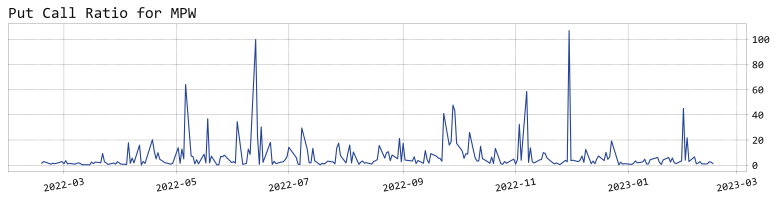

In [16]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.options.pcr_chart(
    symbol,
    window=30,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
pcr_chart = f.getvalue().decode("utf-8")

In [17]:
#expiry_dates = openbb.stocks.options.expirations(symbol)
#if (len(expiry_dates) > 0):
#    exp = expiry_dates[0]
#    option_chain = openbb.stocks.options.chains(symbol, expiration=exp)
#else:
#    option_chain = pd.DataFrame()


In [18]:
#if not option_chain.empty:
#    fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
#    ax.plot(
#        option_chain["strike"], option_chain["c_Openinterest"], label="Call Open Interest"
#    )
#    ax.plot(
#        option_chain["strike"], option_chain["p_Openinterest"], label="Put Open Interest"
#    )
#    ax.legend()
#    fig.tight_layout()
#    f = io.BytesIO()
#    fig.savefig(f, format="svg")
#    vol_chart = f.getvalue().decode("utf-8")

In [19]:
#if not option_chain.empty:
#    fig, ax = plt.subplots(figsize=(11, 8), dpi=150)
#    ax.plot(option_chain["strike"], option_chain["c_Volume"], label="Call Volume")
#    ax.plot(option_chain["strike"], option_chain["p_Volume"], label="Put Volume")
#    ax.legend()
#    fig.tight_layout()
#    f = io.BytesIO()
#    fig.savefig(f, format="svg")
#    voi_chart = f.getvalue().decode("utf-8")

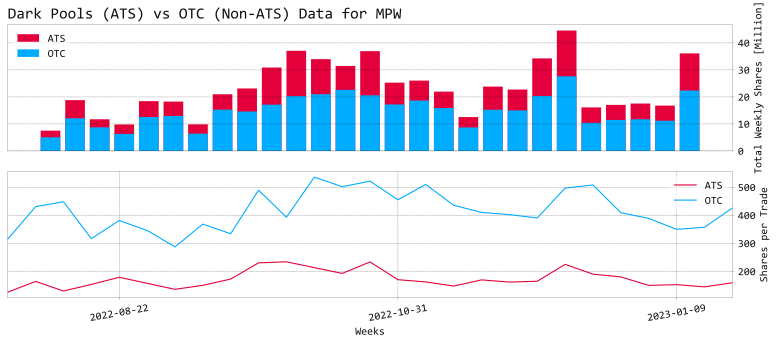

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.dps.dpotc_chart(symbol=symbol, external_axes=[ax1, ax2])
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
dark_pools = f.getvalue().decode("utf-8")

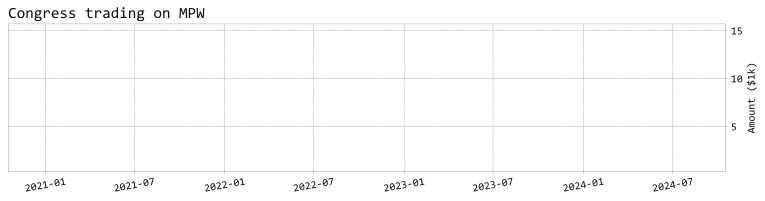

In [21]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.gtrades_chart(
    symbol,
    past_transactions_months=12,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gtrades_chart = f.getvalue().decode("utf-8")

No government contracts found

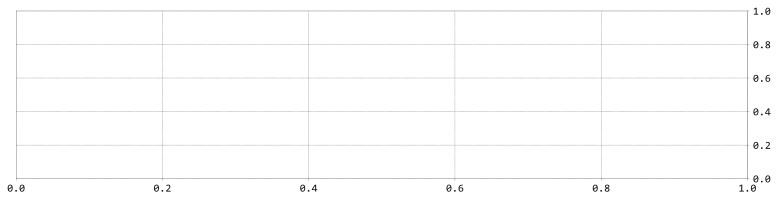

In [22]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.contracts_chart(
    symbol,
    past_transaction_days=365,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_contracts_chart = f.getvalue().decode("utf-8")

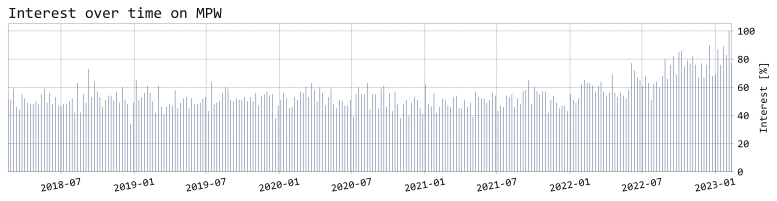

In [23]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.mentions_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_mentions_chart = f.getvalue().decode("utf-8")

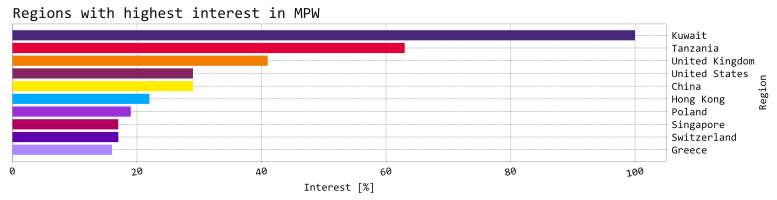

In [24]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.regions_chart(
    symbol,
    limit=10,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_regions_chart = f.getvalue().decode("utf-8")

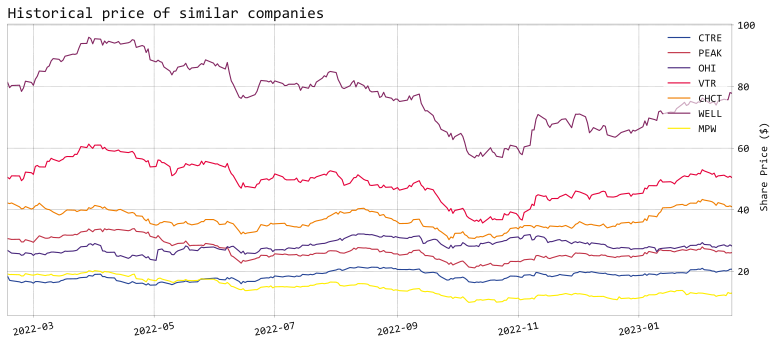

In [25]:

                    
                        
if (symbol in similar_companies_dict):
    similar_companies = similar_companies_dict[symbol]
else:
    similar_companies=openbb.stocks.ca.similar(symbol,source="Polygon")

similar_companies.append(symbol)
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hist_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
    normalize=False,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
historical_similar = f.getvalue().decode("utf-8")

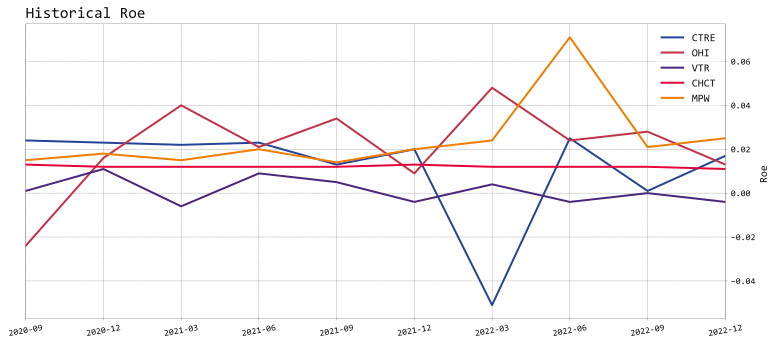

In [66]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric(similar_companies,"Roe", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
roic_chart = f.getvalue().decode("utf-8")

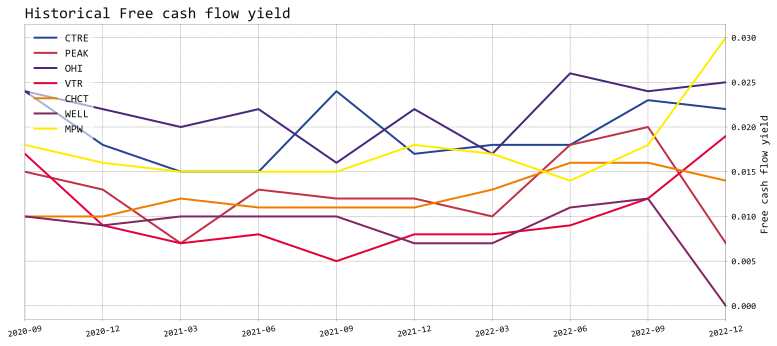

In [27]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric(similar_companies,"Free cash flow yield", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
fcf_yield_chart = f.getvalue().decode("utf-8")

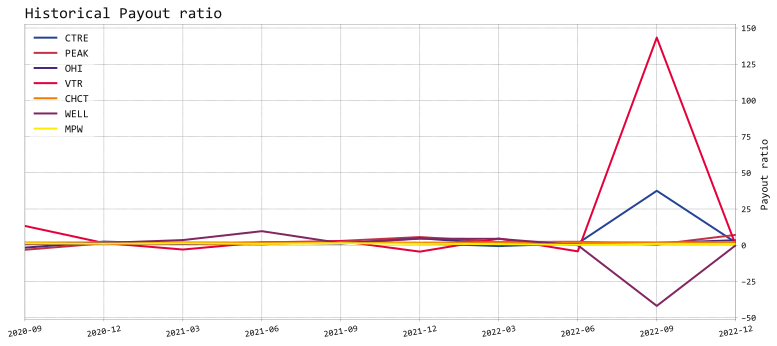

In [28]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric(similar_companies,"Payout ratio", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
payout_ratio_chart = f.getvalue().decode("utf-8")

In [67]:
df_historical_ratios=openbb.stocks.fa.ratios(symbol=symbol,quarterly=True,limit=16)
df_historical_ratios

Fiscal Date Ending,2022-09,2022-06,2022-03,2021-12,2021-09,2021-06,2021-03,2020-12,2020-09,2020-06,2020-03,2019-12,2019-09,2019-06,2019-03,2018-12
Period,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4
Current ratio,1.083,0.843,0.910,4.062,1.782,3.282,4.577,3.365,2.398,3.577,3.366,8.450,1.868,4.775,7.185,6.466
Quick ratio,1.083,2.224,0.910,7.304,1.708,3.282,4.577,3.219,2.398,3.577,3.366,8.140,1.868,4.775,7.185,6.200
Cash ratio,0.244,0.171,0.217,0.725,0.232,0.813,1.195,0.910,0.280,0.846,1.168,5.017,0.659,1.934,4.390,3.532
Days of sales outstanding,1.065 K,921.821,706.590,1.885 K,2.082 K,2.093 K,2.126 K,1.525 K,1.540 K,1.515 K,1.168 K,1.296 K,1.376 K,1.258 K,1.282 K,1.253 K
Days of inventory outstanding,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Operating cycle,262.558,227.298,174.228,464.674,513.297,516.147,524.127,376.127,379.647,373.558,287.896,319.523,339.185,310.192,316.076,308.958
Days of payables outstanding,0,2.394 K,0,6.983 K,0,0,0,6.913 K,6.581 K,0,0,0,0,0,0,0
Cash conversion cycle,262.558,-2.167 K,174.228,-6.519 K,513.297,516.147,524.127,-6.537 K,-6.201 K,373.558,287.896,319.523,339.185,310.192,316.076,308.958
Gross profit margin,0.977,0.947,0.979,0.981,0.982,0.951,0.985,0.983,0.982,0.966,0.981,0.966,0.982,0.957,0.983,0.987


In [29]:
df_historical_metrics=openbb.stocks.fa.metrics(symbol=symbol,quarterly=True,limit=16)
df_historical_metrics

Fiscal Date Ending,2022-09,2022-06,2022-03,2021-12,2021-09,2021-06,2021-03,2020-12,2020-09,2020-06,2020-03,2019-12,2019-09,2019-06,2019-03,2018-12
Period,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4
Revenue per share,0.588,0.668,0.685,0.686,0.657,0.650,0.630,0.622,0.620,0.553,0.564,0.520,0.511,0.488,0.474,0.493
Net income per share,0.370,0.317,1.055,0.346,0.288,0.195,0.284,0.205,0.247,0.207,0.155,0.263,0.204,0.201,0.199,0.214
Operating cash flow per share,0.357,0.275,0.300,0.393,0.357,0.300,0.328,0.327,0.288,0.345,0.205,0.338,0.294,0.282,0.228,0.409
Free cash flow per share,0.357,0.275,0.300,0.393,0.357,0.300,0.328,0.327,0.288,0.345,0.205,0.338,0.294,0.282,0.228,0.409
Cash per share,0.499,3.898,0.416,4.213,0.588,1.228,1.296,1.024,0.346,0.710,0.960,2.963,1.050,1.145,2.616,2.239
Book value per share,14.745,14.795,14.889,14.152,14.036,13.977,14.083,13.666,13.571,13.390,13.400,14.239,13.589,12.444,12.815,12.402
Tangible book value per share,14.747,-8.067,14.898,-9.418,14.045,13.986,14.092,11.257,-7.762,13.391,13.400,14.239,13.619,12.478,12.851,12.439
Shareholders equity per share,14.745,14.795,14.889,14.152,14.036,13.977,14.083,13.666,13.571,13.390,13.400,14.239,13.589,12.444,12.815,12.402
Interest debt per share,16.212,17.336,17.331,19.448,18.044,17.353,17.629,16.509,15.577,14.923,14.902,14.372,14.015,12.496,10.706,11.150


In [30]:
#fig, ax = plt.subplots(figsize=(11,5), dpi=150)
#dhelp.display_historical_metric(similar_companies,"EBITDA_MARGIN", external_axes=[
#        ax,
#    ])

#fig.tight_layout()
#f = io.BytesIO()
#fig.savefig(f, format="svg")
#ebitda_margin_chart = f.getvalue().decode("utf-8")

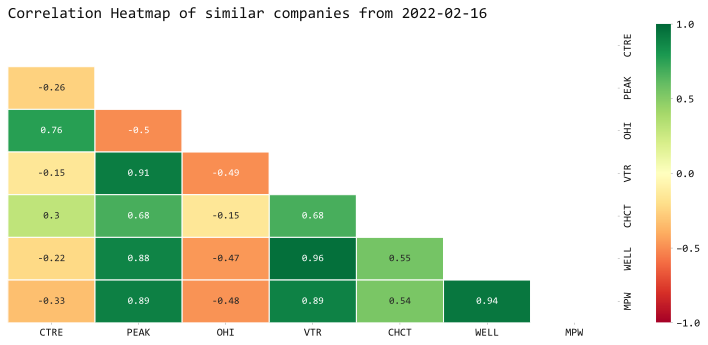

In [31]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hcorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
hcorr_similar = f.getvalue().decode("utf-8")

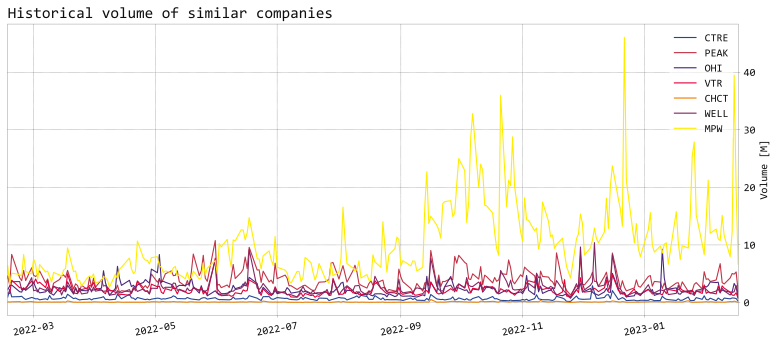

In [32]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.volume_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
vol_similar = f.getvalue().decode("utf-8")

Request error in retrieving PEAK sentiment from FinBrain API

Request error in retrieving WELL sentiment from FinBrain API

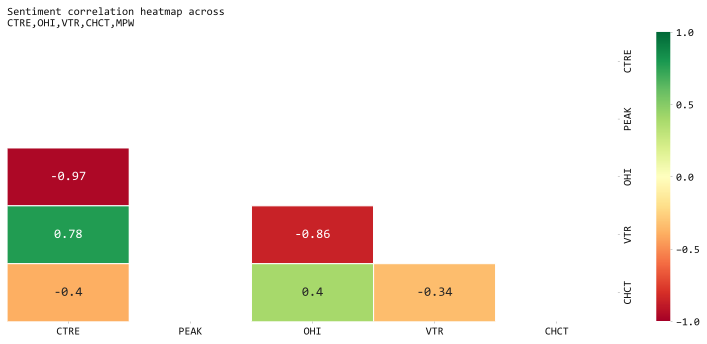

In [33]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.scorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
scorr_similar = f.getvalue().decode("utf-8")

In [34]:
valuation_comparison = openbb.stocks.ca.screener(similar_companies, "valuation")
valuation_comparison = valuation_comparison.drop(columns=['Change', 'Volume', 'Price', 'EPS next 5Y', 'PEG', 'Sales past 5Y'])
valuation_comparison['Market Cap']=valuation_comparison['Market Cap'].apply(lambda x: "${0:.0f} M".format(x/1000000))

valuation_comparison = valuation_comparison.style.format({"EPS this Y": "${:,.2f}", "EPS next Y": "${:,.2f}", "EPS past 5Y": "${:,.2f}", 
                                                          "P/E": "{:,.2f}", "Fwd P/E":"{:,.2f}", "P/S": "{:,.2f}" , "P/B": "{:,.2f}" , 
                                                          "P/C":"{:,.2f}", "P/FCF": "{:,.2f}"} 
                                                        )
                                                      
#valuation_comparison['EPS this Y']=valuation_comparison['EPS this Y'].apply(lambda x: "${:,.2f}".format(x))

valuation_comparison

,Ticker,Market Cap,P/E,Fwd P/E,P/S,P/B,P/C,P/FCF,EPS this Y,EPS next Y,EPS past 5Y
0,CHCT,$1020 M,48.19,37.50,10.69,2.03,378.43,159.65,$0.09,$0.17,$0.29
1,CTRE,$1980 M,nan,16.71,10.21,2.36,150.12,63.92,$-1.11,$0.08,$-0.17
2,MPW,$7530 M,6.15,10.26,4.79,0.87,25.16,1.79,$0.37,$-0.38,$0.05
3,OHI,$6590 M,16.41,21.10,7.50,1.82,48.85,nan,$1.52,$0.12,$-0.01
4,VTR,$20170 M,nan,145.43,4.92,1.92,139.01,136.47,$-0.89,$0.50,$-0.40


In [35]:
financial_comparison = openbb.stocks.ca.screener(similar_companies, "financial")
financial_comparison = financial_comparison.drop(columns=['Change', 'Volume', 'Earnings', 'Price','Market Cap'])
financial_comparison['Dividend']=financial_comparison['Dividend'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROA']=financial_comparison['ROA'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROE']=financial_comparison['ROE'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROI']=financial_comparison['ROI'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Gross M']=financial_comparison['Gross M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Oper M']=financial_comparison['Oper M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Profit M']=financial_comparison['Profit M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison= financial_comparison.fillna("")
#financial_comparison = financial_comparison.rename(columns={'Gross M': 'Gross Margin', 'Oper M': 'Operating Margin', 'Profit M': 'Profit Margin'})
financial_comparison

,Ticker,Dividend,ROA,ROE,ROI,Curr R,Quick R,LTDebt/Eq,Debt/Eq,Gross M,Oper M,Profit M
0,CHCT,5.3%,2.6%,4.3%,4.5%,,,0.66,0.66,83.2%,35.4%,21.1%
1,CTRE,5.3%,-0.5%,-0.9%,2.1%,,,0.85,0.85,97.8%,17.2%,-4.1%
2,MPW,9.1%,6.3%,14.2%,4.9%,,,1.07,1.07,97.1%,65.8%,79.4%
3,OHI,9.4%,4.7%,11.8%,2.7%,,,1.43,1.43,98.2%,31.0%,51.4%
4,VTR,3.5%,0.1%,0.1%,1.3%,,,1.15,1.15,44.5%,8.9%,0.4%


In [36]:
ownership_comparison = openbb.stocks.ca.screener(similar_companies, "ownership")
ownership_comparison = ownership_comparison.drop(columns=['Market Cap', 'Change', 'Volume', 'Avg Volume', 'Price'])
ownership_comparison= ownership_comparison.fillna("")
ownership_comparison

,Ticker,Outstanding,Float,Insider Own,Insider Trans,Inst Own,Inst Trans,Float Short,Short Ratio
0,CHCT,23590000.0,23530000.0,0.0640,0.0000,0.931,-0.0394,0.0280,5.92
1,CTRE,97230000.0,95300000.0,0.0185,0.0000,0.891,0.0257,0.0297,4.11
2,MPW,598980000.0,592640000.0,0.0120,0.0000,0.841,0.0049,0.1733,7.55
3,OHI,234790000.0,233260000.0,0.0039,0.0000,0.666,0.0029,0.0992,10.57
4,VTR,399650000.0,397860000.0,0.0051,-0.0163,0.951,-0.0059,0.0200,3.93


In [37]:
performance_comparison = openbb.stocks.ca.screener(similar_companies, "performance")
performance_comparison = performance_comparison.drop(columns=['Rel Volume', 'Avg Volume', 'Price','Change','Volume'])
performance_comparison['Perf Week']=performance_comparison['Perf Week'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Month']=performance_comparison['Perf Month'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Quart']=performance_comparison['Perf Quart'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Half']=performance_comparison['Perf Half'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Year']=performance_comparison['Perf Year'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf YTD']=performance_comparison['Perf YTD'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison= performance_comparison.fillna("")
performance_comparison

,Ticker,Perf Week,Perf Month,Perf Quart,Perf Half,Perf Year,Perf YTD,Volatility W,Volatility M,Recom
0,CHCT,-3.4%,-0.7%,20.4%,2.6%,-7.4%,14.2%,0.0281,0.0214,1.8
1,CTRE,3.6%,7.0%,10.7%,-5.6%,6.0%,11.0%,0.0243,0.0240,2.0
2,MPW,6.3%,-3.6%,4.5%,-19.8%,-37.8%,15.4%,0.0414,0.0416,2.1
3,OHI,0.0%,0.5%,-6.1%,-15.3%,-3.9%,0.8%,0.0208,0.0260,2.9
4,VTR,-1.3%,4.1%,15.1%,2.7%,-4.0%,11.7%,0.0235,0.0218,2.2


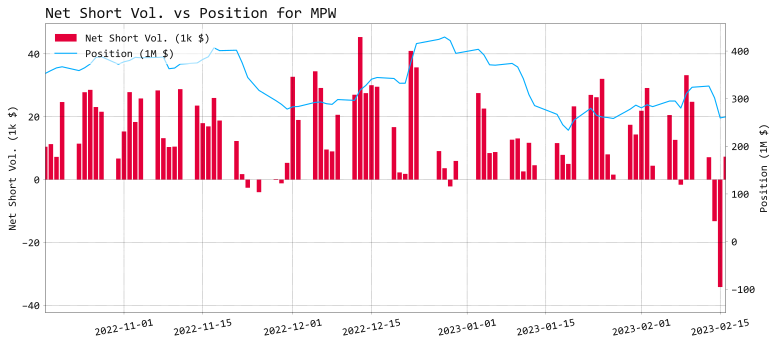

In [38]:
fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.stocks.dps.spos_chart(
    symbol=symbol,
    limit=84,
    raw=False,
    export="",
    external_axes=[ax1, ax2],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
net_short_position = f.getvalue().decode("utf-8")

In [39]:
try:
    df_related_queries = openbb.stocks.ba.queries(symbol)
    df_related_queries.index += 1
    df_related_queries.index
except:
    pass

In [40]:
try:
    df_rising_queries = openbb.stocks.ba.rise(symbol)
    df_rising_queries.index += 1
    df_rising_queries
except:
    pass

No quarterly government contracts found

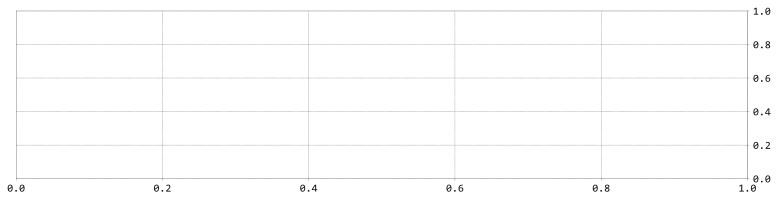

In [41]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.histcont_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_histcont_chart = f.getvalue().decode("utf-8")

In [42]:
df_lobbying = openbb.stocks.gov.lobbying(symbol, limit=5)
df_lobbying

No corporate lobbying found

""


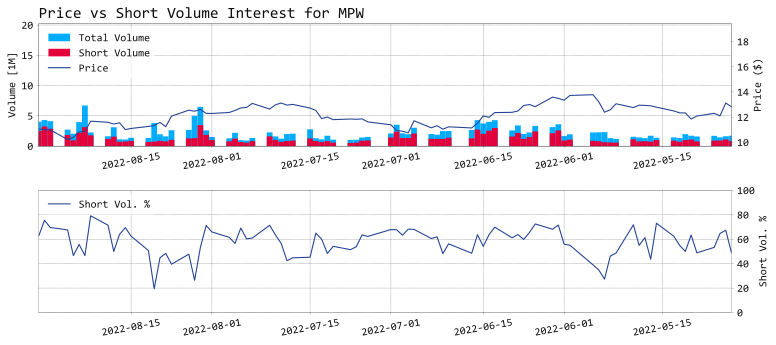

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax3 = ax1.twinx()
openbb.stocks.dps.psi_sg_chart(
    symbol=symbol,
    external_axes=[ax1, ax2, ax3],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_vs_short_interest = f.getvalue().decode("utf-8")

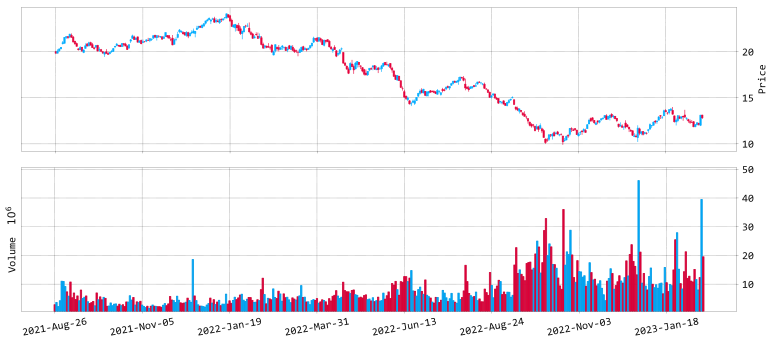

In [44]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

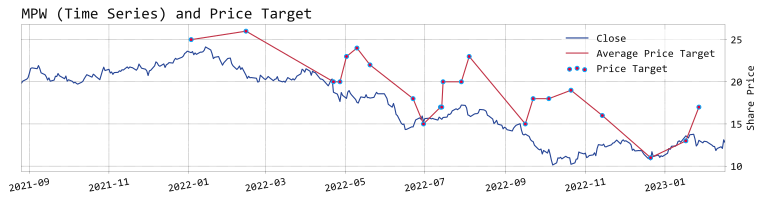

In [45]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.pt_chart(
    symbol=symbol,
    start_date="2022-01-01",
    data=ticker_data,
    limit=10,
    raw=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
price_target_chart = f.getvalue().decode("utf-8")

In [46]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days = 0
days = 0
if not df.empty:
    df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]
    while df_ratings.empty:
        days += 30
        df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]

        if days > 100:
            break

    if not df_ratings.empty:
        avg_ratings_last_30_days = round(np.mean(df_ratings["Price Target"].values), 2)
    else:
        avg_ratings = 0

last_price = round(ticker_data["Close"][-1], 2)

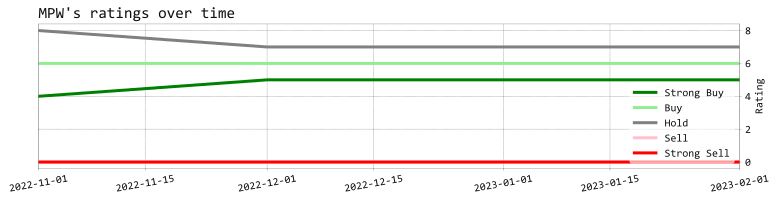

In [47]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot_chart(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

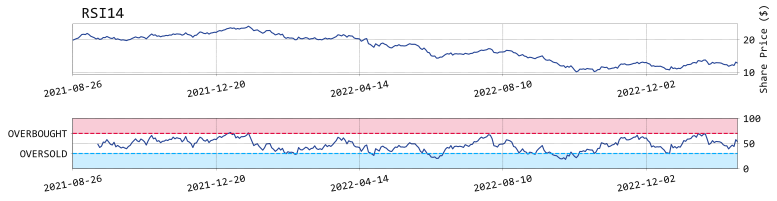

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.ta.rsi_chart(ticker_data["Close"], external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [49]:
df = openbb.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

53.42

In [50]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [51]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(openbb.stocks.ins.lins(symbol=symbol)).head(10)
if (df_insider.empty):
    print("empty")
    last_10_insider_trading = 0
else:
    df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
    df_insider["Trade"] = df_insider.apply(
        lambda row: (-1 * float(row["Val ($)"]))
        if row["Transaction"] == "Sale"
        else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
        axis=1,
    )
    last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
    df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
    df_insider

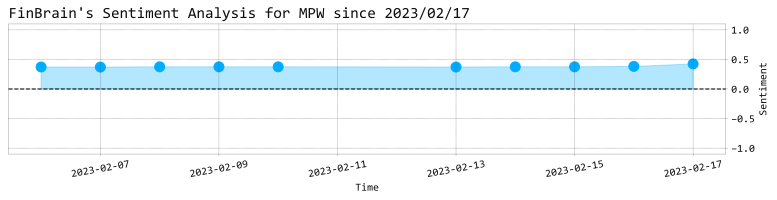

In [52]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.headlines_chart(symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
finbrain_sentiment = f.getvalue().decode("utf-8")

In [53]:
df_sentiment_finbrain = openbb.stocks.ca.sentiment(symbols=[symbol])
# comment out
#finbrain_sentiment_val = float(df_sentiment_finbrain.values[-1][0])
finbrain_sentiment_val = 0

In [54]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"
stocktwits_sentiment

'Watchlist count: 4879</br>\nLast 4 sentiment messages:</br>Bullish 100.0%</br>Bearish 0.0%'

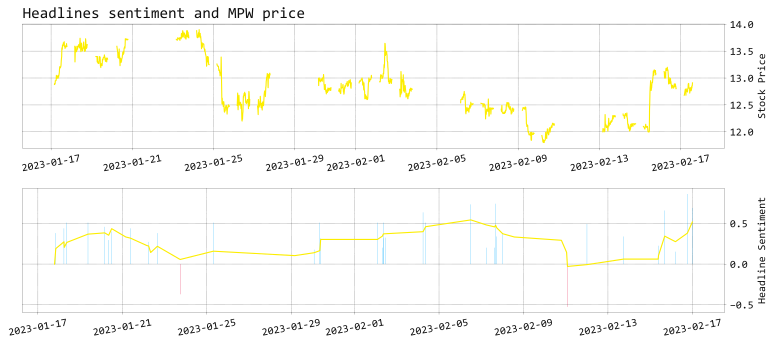

In [55]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.ba.snews_chart(symbol, external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
snews = f.getvalue().decode("utf-8")

In [56]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol,
    start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21),
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

Loading Daily data for MPW with starting period 2019-09-06.

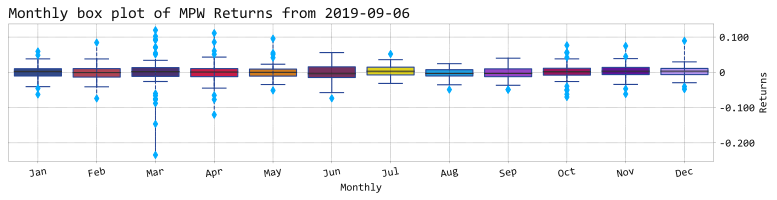

In [57]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_month = f.getvalue().decode("utf-8")

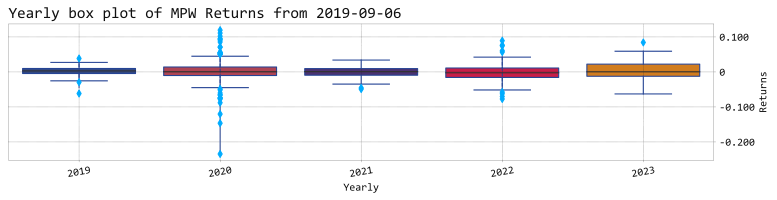

In [58]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=True,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_year = f.getvalue().decode("utf-8")

In [59]:
income_df = openbb.stocks.fa.income(symbol, source="YahooFinance")
income_df = income_df/1000000
income_df = income_df.applymap("${0:.0f}M".format)

mgmt_df = openbb.stocks.fa.mgmt(symbol)
if (mgmt_df.empty):
    print ("empty")
else:
    mgmt_df["Info"] = mgmt_df["Info"].apply(lambda x: f'<a href="{x}">{x}</a>')
    mgmt_df["Insider Activity"] = mgmt_df["Insider Activity"].apply(
        lambda x: f'<a href="{x}">{x}</a>' if x != "-" else x
    )
try:
    hist_dcf = openbb.stocks.fa.dcf(symbol)
except:
    pass
enterprise_df = openbb.stocks.fa.enterprise(symbol)
score = openbb.stocks.fa.score(symbol)
if score:
    score = round(float(score), 2)

No management information in Business Insider for MPW

empty


Ticker should be a NASDAQ 100 ticker or SP 500 ticker

In [60]:
hist_ratios = openbb.stocks.fa.ratios(symbol)
hist_ratios

Fiscal Date Ending,2021,2020,2019,2018,2017
Period,FY,FY,FY,FY,FY
Current ratio,4.062,3.365,8.450,6.466,0.610
Quick ratio,7.304,3.219,8.140,6.200,0.557
Cash ratio,0.725,0.910,5.017,3.532,0.163
Days of sales outstanding,499.390,407.600,389.024,288.410,214.817
Days of inventory outstanding,0,0,0,0,0
Operating cycle,499.390,407.600,389.024,288.410,214.817
Days of payables outstanding,5.674 K,6.434 K,0,0,0
Cash conversion cycle,-5.175 K,-6.026 K,389.024,288.410,214.817
Gross profit margin,0.975,0.980,0.972,0.988,0.992


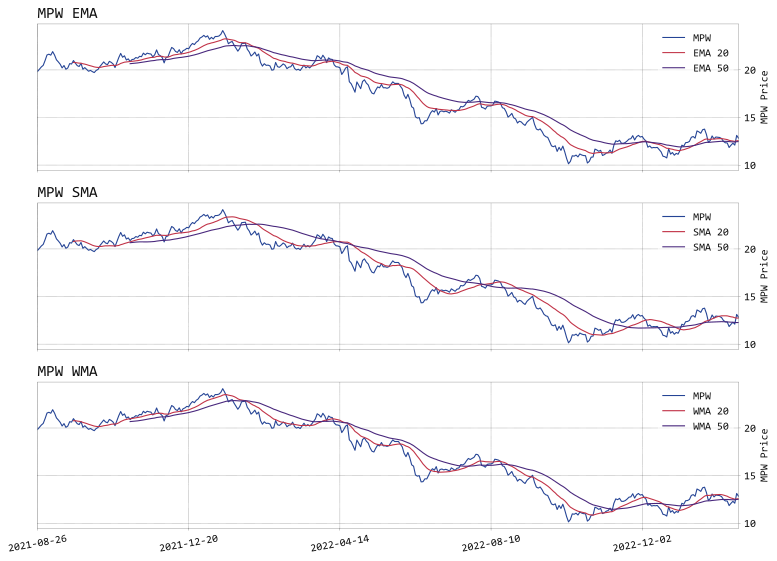

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(11, 8), sharex=True, dpi=150
)
openbb.ta.ma(ticker_data["Close"], symbol=symbol, external_axes=[ax1])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="SMA", external_axes=[ax2])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="WMA", external_axes=[ax3])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ma_chart = f.getvalue().decode("utf-8")

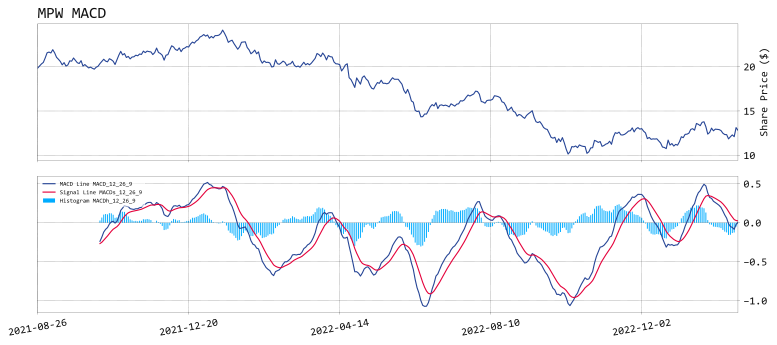

In [62]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.macd_chart(ticker_data["Close"], symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macd_chart = f.getvalue().decode("utf-8")

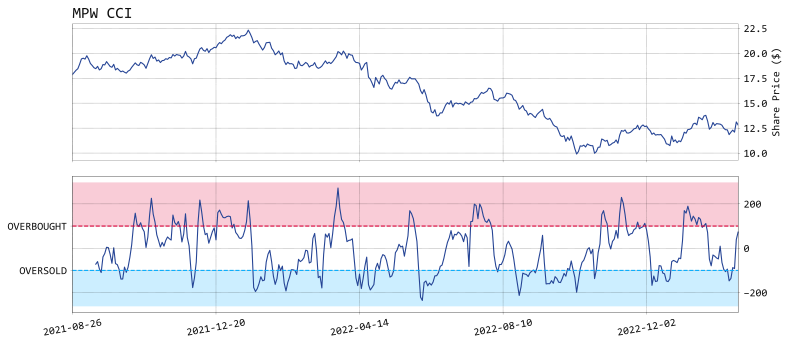

In [63]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.cci_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
cci_chart = f.getvalue().decode("utf-8")

In [64]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.ta.stoch_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
stoch_chart = f.getvalue().decode("utf-8")

Error in callback <function flush_figures at 0x000002278B435EE0> (for post_execute):


KeyboardInterrupt: 

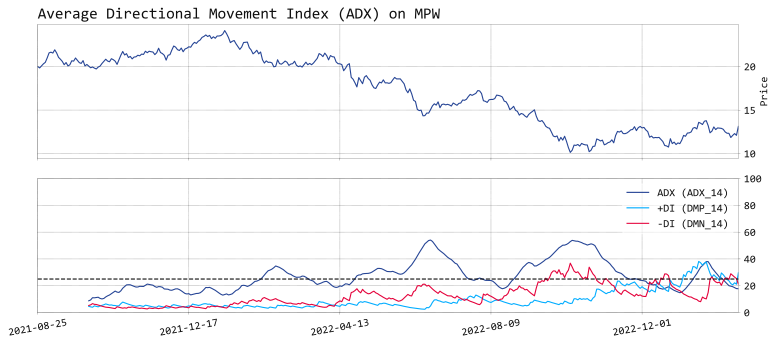

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(11, 5), dpi=150)
openbb.ta.adx_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
adx_chart = f.getvalue().decode("utf-8")

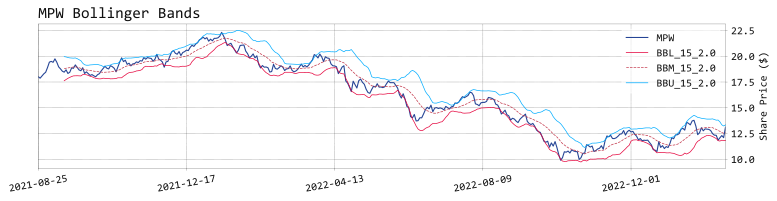

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.ta.bbands_chart(ticker_data, symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bbands_chart = f.getvalue().decode("utf-8")

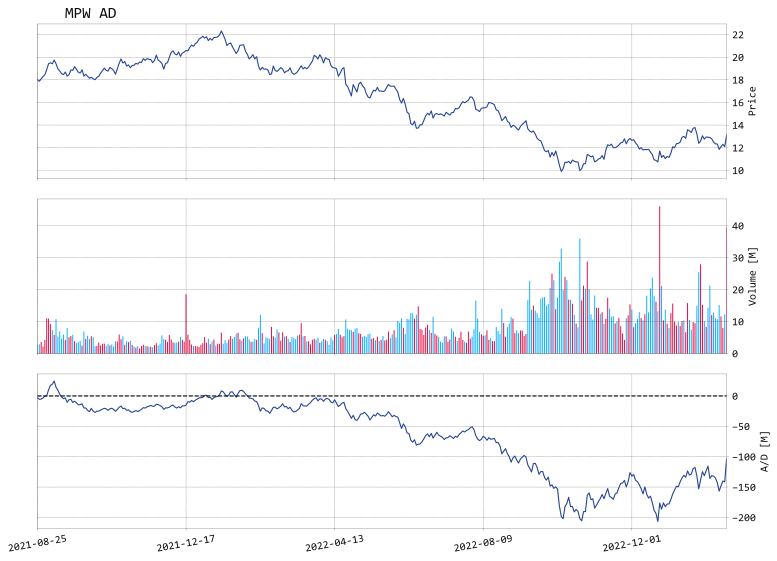

In [ ]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(11, 8), dpi=150)
openbb.ta.ad_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ad_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [ ]:
body =""
    
img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/NYSE-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR key facts</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-symbol-profile.js" async>
                {{
                "width": "1085",
                "height": "500",
                "colorTheme": "light",
                "isTransparent": false,
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

if (investor_report_url): 
    htmlcode += widgets.row([widgets.h(3, "Investor Presentation for " + symbol)])
    htmlcode += f"""
        <div class="hcontainer">
            <div class="item">
                <iframe src="{investor_report_url}" width="1085" height="700"></iframe>
            </div>
        </div>
            """

            
body += widgets.add_tab("Summary", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
        <div class="tradingview-widget-container">
        <div id="tradingview_fceac"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR stock price</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
        <script type="text/javascript">
        new TradingView.MediumWidget(
            {{
            "symbols": [
                [
                "{long_name}",
                "{exchange}:{symbol}|1D"
                ]
            ],
            "chartOnly": false,
            "width": "1085",
            "height": "700",
            "locale": "en",
            "colorTheme": "light",
            "autosize": false,
            "showVolume": false,
            "hideDateRanges": false,
            "hideMarketStatus": false,
            "scalePosition": "right",
            "scaleMode": "Normal",
            "fontFamily": "-apple-system, BlinkMacSystemFont, Trebuchet MS, Roboto, Ubuntu, sans-serif",
            "fontSize": "10",
            "noTimeScale": false,
            "valuesTracking": "1",
            "chartType": "line",
            "container_id": "tradingview_fceac"
            }}
        );
        </script>
        </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

body += widgets.add_tab("Overview", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Latest News for " + symbol)])
try:
    for table in tables:
        htmlcode += widgets.row(
            [widgets.h(4, table[1]["title"]) + table[0].to_html(escape=False)]
        )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Twitter News for " + symbol )])

htmlcode += """
<div class="hcontainer">
    <div class="item">
        <div class="tweet-list">
            {% for tweet in tweets %}
            <div class="tweet">
                <div class="tweet-header">
                    <img src="{{ tweet.user.profile_image_url }}" alt="{{ tweet.user.name }}'s profile picture">
                    <h3>{{ tweet.user.name }}</h3>                   
                </div>       
                <div class="tweet-body">
                    <p>{{ tweet.full_text }}</p>
                </div>   
                {% if tweet.entities.media %}
                    <div class="tweet-media">
                    {% for media in tweet.entities.media %}
                        <img src="{{ media.media_url_https }}" alt="Tweet media">
                    {% endfor %}
                    </div>
                {% endif %}
                <div class="tweet-footer">
                    {% set date = tweet.created_at.strftime('%b %d, %Y at %I:%M %p') %}
                    <p>{{ date }}</p>
                    <a href="https://twitter.com/{{ tweet.user.screen_name }}/status/{{ tweet.id }}" target="_blank">View on Twitter</a>
                </div>
            </div>
            {% endfor %}
        </div>
    </div>
</div>
        """

body += widgets.add_tab("News and Twitter", htmlcode, False)

if(morningstar_report_url):
    htmlcode = widgets.row([widgets.h(3, "Morningstar analysis " + symbol)])
    htmlcode += f"""
            <div class="hcontainer">
                <div class="item">
                <iframe src="{morningstar_report_url}" width="1085" height="700" allow="autoplay"></iframe>
                </div>
            </div>
                """
else:
    htmlcode = widgets.row([widgets.h(3, "Morningstar analysis not available ")])

htmlcode += widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart]
)
try:
    htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "Analyst Recommendations") + df_rating.head(15).to_html()]
    )
except:
    pass

body += widgets.add_tab("Analyst Opinions", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/financials-overview/" rel="noopener" target="_blank"><span class="blue-text">AR fundamentals</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-financials.js" async>
                {{
                "colorTheme": "light",
                "isTransparent": false,
                "largeChartUrl": "",
                "displayMode": "regular",
                "width": "1085",
                "height": "800",
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

#try:
#    htmlcode += widgets.row(
#        [widgets.h(3, "Shares outstanding ") + shares_outstanding_chart]
#    )
#except:
#    pass

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
    )
except:
    pass

htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, "Major Institutional Shareholders")
            + df_institutional_shareholders.head().to_html()
        ]
    )
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, f"Historical DCF for {symbol}") + hist_dcf.to_html()]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Enterprise data for {symbol}") + enterprise_df.to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Income Statement for {symbol}") + income_df.to_html()]
)
try:
    htmlcode += widgets.row([widgets.h(3, f"Data for {symbol}") + data_df.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
    )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Ratios") + hist_ratios.to_html(escape=False)])

body += widgets.add_tab("Fundamental Analysis", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Put to call ratio") + pcr_chart])
#if not option_chain.empty:
#    htmlcode += widgets.row(
#        [widgets.h(3, "Option Volume for closest expiry date") + vol_chart]
#    )
#    htmlcode += widgets.row(
#        [widgets.h(3, "Volume and Open Interest for closest expiry date") + voi_chart]
#    )
#try:
#    htmlcode += widgets.row([widgets.h(3, "Option Chains") + options_df.to_html()])
#except:
#    pass
body += widgets.add_tab("Options", htmlcode, False)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
body += widgets.add_tab("Shorts", htmlcode, False)

htmlcode = widgets.row(
    [widgets.h(3, "Strong ROIC and Operating Margins are signal of presence of moat")]
)

htmlcode = widgets.row(
    [
        widgets.h(3, f"Return on invested capital for companies similar to {symbol}")
        + roic_chart
    ]
)

htmlcode += widgets.row(
    [
        widgets.h(3, f"Free Cash Flow Yield of companies similar to {symbol}")
        + fcf_yield_chart
    ]
)

htmlcode += widgets.row(
        [
        widgets.h(3, f"Payout ratio for companies similar to {symbol}")
        + payout_ratio_chart
    ]
)

htmlcode += widgets.row(
    [
        widgets.h(3, f"Price over the past year for companies similar to {symbol}")
        + historical_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Price correlation with similar companies for {symbol}")
        + hcorr_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Volume over the past year for companies similar to {symbol}")
        + vol_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Sentiment correlation with similar companies for {symbol}")
        + scorr_similar
    ]
)

try:
    htmlcode += widgets.row([widgets.h(3, "Valuation Comparison") + valuation_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Financials Comparison") + financial_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Ownership Comparison") + ownership_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Performance Comparison") + performance_comparison.to_html()])
except:
    pass

htmlcode += widgets.row(
    [
        widgets.p(
            "Note that similar companies have been found using openbb.stocks.ca.similar"
        )
    ]
)
body += widgets.add_tab("Comparison", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/technicals/" rel="noopener" target="_blank"><span class="blue-text">AR stock analysis</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-technical-analysis.js" async>
                {{
                "interval": "1W",
                "width": "1085",
                "isTransparent": false,
                "height": "700",
                "symbol": "{exchange}:{symbol}",
                "showIntervalTabs": true,
                "locale": "en",
                "colorTheme": "light"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
        """

htmlcode += widgets.row([widgets.h(3, f"Moving Averages for {symbol}") + ma_chart])
htmlcode += widgets.row([macd_chart])
htmlcode += widgets.row([ta_rsi])
htmlcode += widgets.row([stoch_chart])
htmlcode += widgets.row([cci_chart])
htmlcode += widgets.row([ad_chart])
htmlcode += widgets.row([bbands_chart])
htmlcode += widgets.row([adx_chart])
body += widgets.add_tab("Technical Analysis", htmlcode, False)

try:
    htmlcode = widgets.row(
        [widgets.h(3, "Last Activity") + df_insider.head(10).to_html(col_space="75px")]
    )
except:
    pass
body += widgets.add_tab("Insider Trading", htmlcode, False)

htmlcode = widgets.row([bw_year])
htmlcode += widgets.row([bw_month])
body += widgets.add_tab("Quantitative Analysis", htmlcode, False)


htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [
        widgets.h(3, "Interest in " + symbol + " based on google analytics")
        + google_mentions_chart
    ]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Regions with highest interest in {symbol}") + google_regions_chart]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top queries related to {symbol}")
            + df_related_queries.to_html()
        ]
    )
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top rising queries related to {symbol}")
            + df_rising_queries.to_html()
        ]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Stocktwits sentiment for {symbol}") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode, False)

htmlcode = """
    <iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTzYPt7GjAVk-NLvYrDo5OuxcDuaRFejqZ2iT_l2Y3nkKtAgwNO809hYnZhCIxc8XGQSDuGSfc8ZsAy/pubhtml?widget=true&amp;headers=false" width="1085" height="700"></iframe>
        """

body += widgets.add_tab("GSheets", htmlcode, False)

#This code snippet was extracted from OpenBB widget_helpers.py so that the html can be modified to work with the dashboard
body += """
        <script>
        function dmenu2(evt, menu_name) {
            event.preventDefault();
            var i, tabcontent, tablinks;
            tabcontent = document.getElementsByClassName("tabcontent");
            for (i = 0; i < tabcontent.length; i++) {
                tabcontent[i].style.display = "none";
            }
            tablinks = document.getElementsByClassName("tablinks");
            for (i = 0; i < tablinks.length; i++) {
                tablinks[i].className = tablinks[i].className.replace(" active bg-gradient-primary", "");
            }

            document.getElementById(menu_name).style.display = "block";
            evt.currentTarget.className += " active bg-gradient-primary";
        }
        window.onload = function() {
            dmenu2(event, 'Summary');
        };
        </script>"""

f = open("public/templates/report.j2", "r")
template = Template(f.read())
report= template.render(title=report_name, stylesheet=stylesheet, body=body + "</html>")

# to save the results
with open("public/templates/" + report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

dotenv.load_dotenv(USER_ENV_FILE)
cfg.theme = TerminalStyle(
    os.getenv("OPENBB_MPLSTYLE") or "dark",
    os.getenv("OPENBB_MPFSTYLE") or "dark",
    os.getenv("OPENBB_RICHSTYLE") or "dark",
)